# Uncertainty propagation

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the free [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to use of Python and NumPy for uncertainty propagation. It uses some Python 3 features. It compares the use of the [Python uncertainties library](https://pythonhosted.org/uncertainties/) with a stochastic simulation. 

In [1]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

The *body mass index* (BMI) is the ratio $\frac{\text{body mass } (kg)}{\text{body height} (m)^2}$. It is often used as an (imperfect) indicator or obesity or malnutrition. 
      
**Task**: calculate your BMI and the associated uncertainty interval, assuming that:
   
- your weight scale tells you that you weigh 84 kg (precision shown to the nearest kilogram)
      
- a tape measure says you are between 181 and 182 cm tall (most likely value is 181.5 cm)

## Solution using the uncertainties library

The `uncertainties` library implements [**linear error propagation theory**](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) in Python. The uncertainties library can be installed (if you’re using a Linux machine) using a command such as 

> sudo pip install uncertainties

or perhaps if you're using Python3, 

> sudo pip3 install uncertainties

In [2]:
import uncertainties

x = uncertainties.ufloat(10, 0.5)
x

10.0+/-0.5

This defines an uncertain number (a random variable) with a central value of 10 and a standard deviation of 0.5. The standard deviation represents the uncertainty, or the error, in our number. The uncertainties package is able to do various types of arithmetic and other mathematical operations on these uncertain numbers, and propagates the uncertainty to the result. For example, we can multiply this uncertain number by two:

In [3]:
2 * x

20.0+/-1.0

Note that the uncertainty range concerning our value has been multiplied by two, along with the value itself.

We can add the uncertain number to itself:

In [4]:
x + x + x

30.0+/-1.5

We can also add a very uncertain number to `x`:

In [5]:
y = uncertainties.ufloat(1, 10)
x + y

11.0+/-10.012492197250394

or we can add a certain number (a number with zero uncertainty) to `x`:

In [6]:
x + 5

15.0+/-0.5

Note that the uncertainties package is able to determine that the error range in the expression below is zero (this is because the subtracted quantities are **correlated** to the first value). 

In [7]:
2 * x - x - x

0.0+/-0

The uncertainties package is also able to propagate uncertainty through more complicated mathematical expressions:

In [8]:
import uncertainties.umath

x**2 + 45*uncertainties.umath.sin(x + y)

55.000440705218345+/-10.294066614145805

You can use it as a convenient calculator for mathematical expressions including uncertainty. The library is also useful to add uncertainty propagation to existing Python code, which you can often reuse without any modifications.

Coming back to our initial objective, recall that we want to calculate the **body mass index** (BMI) of a person, using the formula given above, from uncertain measurements of the person's mass and height. The description of measurements given in the introduction indicates that:

- weight is a uniform probability distribution between 83.5 and 84.5 kg

- height is a triangular probability distribution between 1.81 and 1.82 m with a central value of 1.815. 

To create appropriate random variables using the uncertainties package, we need to know their central value and standard deviation. We can calculate the standard deviations using `scipy.stats`.

In [9]:
import scipy.stats
# this is for the weight random variable (a uniform distribution)
weight_stdev = scipy.stats.uniform(83.5, 1).std()
weight_stdev

0.28867513459481287

In [10]:
# this is for the height random variable (a triangular distribution)
height_stdev = scipy.stats.triang(loc=1.81, scale=0.01, c=0.5).std()
height_stdev

0.0020412414523193153

In [11]:
weight = uncertainties.ufloat(84, weight_stdev)
height = uncertainties.ufloat(1.815, height_stdev)
BMI = weight/(height**2)
BMI

25.49916900029597+/-0.10473188414630026

## Solution using a Monte Carlo simulation

We can also estimate the body mass index using a Monte Carlo (stochastic simulation) method. Please see [our slides on Monte Carlo methods for risk analysis](https://risk-engineering.org/monte-carlo-methods/) for some background on this method.

25.4999019063618 ± 0.10575866775956698


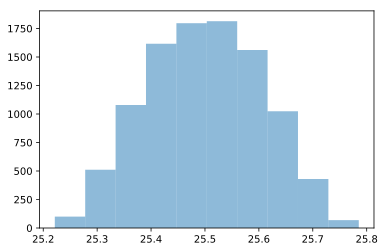

In [12]:
import numpy
from numpy.random import *
import matplotlib.pyplot as plt

# N is the number of runs in our stochastic simulation
N = 10000

def BMI() -> float:
    return uniform(83.5, 84.5) / triangular(1.81, 1.815, 1.82)**2

sim = numpy.zeros(N)
for i in range(N):
    sim[i] = BMI()
print("{} ± {}".format(sim.mean(), sim.std()))
plt.hist(sim, alpha=0.5);

Indeed, the result from the stochastic simulation is very close to that obtained using the uncertainties package.

## Limitations

Note: the uncertainties package uses linear error propagation, and is only appropriate when the level of uncertainty is small (it ignores any non-linear terms in the derivatives of each operation in your calculation, which are used to propagate the uncertainties analytically). It also assumes that the uncertainty (or error) in your data follows a normal distribution, which is a good assumption when dealing with measurement errors for example, but is not appropriate in all cases. In particular, it won't be suitable if your uncertainty is asymmetric, or if you need to truncate the uncertainty in some way (for example if you know that your measurements are definitely positive). The documentation provides more information on [the underlying assumptions](https://pythonhosted.org/uncertainties/tech_guide.html). 

Two related but more complex libraries are [soerp](https://pypi.python.org/pypi/soerp) which implements second-order error propagation and [mcerp](https://pypi.python.org/pypi/mcerp) which implements Monte Carlo error propagation. 